### Types of transfer learning 
* **As is**: All the layers are frozen and not trained. The weights are used from pre-trained models. The output layer is also untouched
* **Feature extraction**: The final layer is trained on the new training data. Eg., take EfficientNetB0 architecture Feature Extractor layers, add a new Dense layer and change number of output units suitable to the problem and train only the final layer
* **Fine Tune**: Create a model using existing architectures but we can retrain some of the layers in it apart from adding the final layer. 

In [65]:
import tensorflow as tf

import datetime

import matplotlib.pyplot as plt

In [66]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

In [67]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [68]:
!nvidia-smi

Wed Aug 10 03:58:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |   8966MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [69]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-08-10 03:58:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   134MB/s    in 1.2s    

2022-08-10 03:58:21 (134 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [70]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}.")

There are 2 directories and 0 files in 10_food_classes_10_percent.
There are 10 directories and 0 files in 10_food_classes_10_percent/test.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/steak.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/ramen.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/ice_cream.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/fried_rice.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/chicken_wings.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/hamburger.
There are 0 directories and 250 files in 10_food_classes_10_percent/test/pizza.
There are 10 directori

### Creating Data loader (`image_dataset_from_directory`)
**Note: the method used earlier (ImageDataGenerator) is depricated. We can use `tf.keras.utils.image_dataset_from_directory()` method. However image augmentations we'll need to do to separately using layers -> See [this](https://www.tensorflow.org/tutorials/images/data_augmentation)**

In [71]:
train_dir = '10_food_classes_10_percent/train'
valid_dir = '10_food_classes_10_percent/test'

train_data = tf.keras.utils.image_dataset_from_directory(train_dir, 
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE)
valid_data = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                         label_mode='categorical',
                                                         image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Infer output of `image_dataset_from_directory`
It is an object of `BatchDataset`. We can see one of the element and shape below

In [72]:
i = 0
for element in train_data:
  print(type(element))
  images, labels = element
  print(images.shape, labels.shape)
  i += 1
  if i >= 2:
    break 

<class 'tuple'>
(32, 224, 224, 3) (32, 10)
<class 'tuple'>
(32, 224, 224, 3) (32, 10)


In [73]:
type(train_data), type(valid_data)

(tensorflow.python.data.ops.dataset_ops.BatchDataset,
 tensorflow.python.data.ops.dataset_ops.BatchDataset)

### Setting up callbacks (Things to run while model is training)
Some popular callbacks
1. Tracking experiments with `TensorBoard` Callback
2. Model checkpoint with `ModelCheckPoint` Callback
3. `EarlyStopping` Callback
4. `LearningRateScheduler`

#### Create TensorBoard Callback

In [74]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}.")
  return tensorboard_callback

### Lets explore EfficientNet_B0 and Resnet_v2_50
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5 

In [75]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [76]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as layers

### Create model using tensorflow hub url

In [77]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, 
                                           name='FeaturesExtractorLayer',
                                           input_shape=IMG_SIZE+(3,))
  
  model = tf.keras.Sequential(
      [
          tf.keras.Input(shape=IMG_SIZE+(3,)),
          layers.Rescaling(1./255.), ## Adding it here because we have not used the regular ImageDataGenerator(flow_from_directory) module
          feature_extractor_layer,
          layers.Dense(num_classes, activation='softmax')
      ]
  )
  return model

#### Build model using ResNet50v2 Features extractor

In [78]:
resnet_model = create_model(resnet_url, 10)

In [79]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 FeaturesExtractorLayer (Ker  (None, 2048)             23564800  
 asLayer)                                                        
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [80]:
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

tensorboard_callback = create_tensorboard_callback('/tensorflow_hub', 'resnet_v0')

history1 = resnet_model.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = len(train_data),
    callbacks = [tensorboard_callback],
    validation_data = valid_data,
    validation_steps = len(valid_data)
)

Saving TensorBoard log files to /tensorflow_hub/resnet_v0/20220810-035839.
Epoch 1/5
24/24 [==============================] - 14s 435ms/step - loss: 1.9447 - categorical_accuracy: 0.3333 - val_loss: 1.1353 - val_categorical_accuracy: 0.6520
Epoch 2/5
24/24 [==============================] - 13s 550ms/step - loss: 0.8706 - categorical_accuracy: 0.7560 - val_loss: 0.8137 - val_categorical_accuracy: 0.7488
Epoch 3/5
24/24 [==============================] - 10s 425ms/step - loss: 0.6052 - categorical_accuracy: 0.8253 - val_loss: 0.7304 - val_categorical_accuracy: 0.7600
Epoch 4/5
24/24 [==============================] - 10s 423ms/step - loss: 0.4716 - categorical_accuracy: 0.8840 - val_loss: 0.6869 - val_categorical_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 10s 424ms/step - loss: 0.3687 - categorical_accuracy: 0.9147 - val_loss: 0.6505 - val_categorical_accuracy: 0.7856


In [81]:
resnet_model.evaluate(valid_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.6505 - categorical_accuracy: 0.7856


[0.6504713296890259, 0.7856000065803528]

#### Build model using EfficientNetB0 features extractor

In [82]:
efficientnet_model = create_model(efficientnet_url, 10)
efficientnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 FeaturesExtractorLayer (Ker  (None, 1280)             4049564   
 asLayer)                                                        
                                                                 
 dense_6 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [83]:
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

tensorboard_callback = create_tensorboard_callback('/tensorflow_hub', 'efficientnet_v0')

history2 = efficientnet_model.fit(
    train_data, 
    epochs=EPOCHS,
    validation_data = valid_data,
    steps_per_epoch = len(train_data),
    validation_steps = len(valid_data),
    callbacks = [tensorboard_callback]
)

Saving TensorBoard log files to /tensorflow_hub/efficientnet_v0/20220810-040018.
Epoch 1/5
24/24 [==============================] - 17s 355ms/step - loss: 1.8348 - categorical_accuracy: 0.4720 - val_loss: 1.2648 - val_categorical_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 8s 315ms/step - loss: 1.0471 - categorical_accuracy: 0.7853 - val_loss: 0.8571 - val_categorical_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 8s 319ms/step - loss: 0.7483 - categorical_accuracy: 0.8413 - val_loss: 0.6914 - val_categorical_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 9s 334ms/step - loss: 0.6028 - categorical_accuracy: 0.8667 - val_loss: 0.6035 - val_categorical_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 8s 325ms/step - loss: 0.5107 - categorical_accuracy: 0.8933 - val_loss: 0.5568 - val_categorical_accuracy: 0.8612


In [84]:
efficientnet_model.evaluate(valid_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5568 - categorical_accuracy: 0.8612


[0.556820273399353, 0.8611999750137329]

In [85]:
def plot_loss_accuracy(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['categorical_accuracy']
  val_accuracy = history.history['val_categorical_accuracy']

  epochs = len(loss)
  plt.figure()
  plt.plot(range(epochs), loss, c='g', label='train')
  plt.plot(range(epochs), val_loss, c='r', label='val')
  plt.xlabel('epoch')
  plt.title('loss')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(range(epochs), accuracy, c='g', label='train')
  plt.plot(range(epochs), val_accuracy, c='r', label='val')
  plt.xlabel('epoch')
  plt.title('accuracy')
  plt.legend()
  plt.show()

#### Loss curves

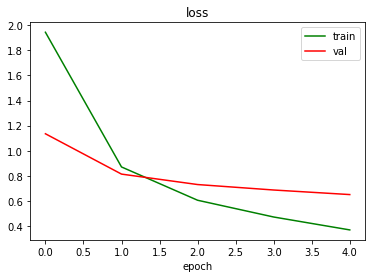

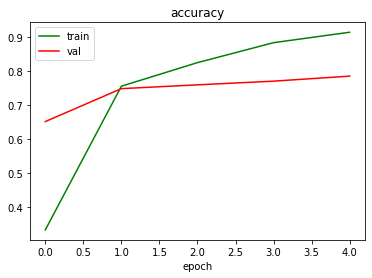

In [86]:
plot_loss_accuracy(history1)

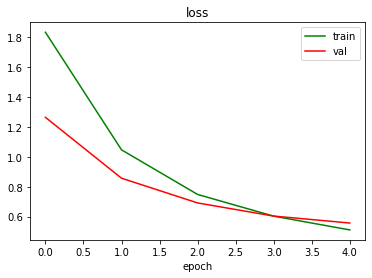

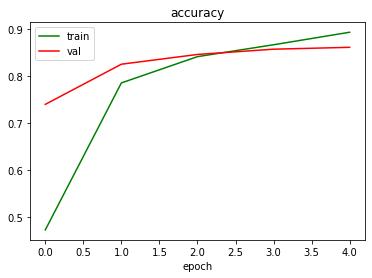

In [87]:
plot_loss_accuracy(history2)

#### Training the EfficientNetv2B0 for longer. 
Since we can see from the loss curves that this model has not overfitted and accuracy is still increasing. So we can train it for longer

In [88]:
efficientnet_model = create_model(efficientnet_url, 10)
efficientnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 FeaturesExtractorLayer (Ker  (None, 1280)             4049564   
 asLayer)                                                        
                                                                 
 dense_7 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [89]:
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

tensorboard_callback = create_tensorboard_callback('/tensorflow_hub', 'efficientnet_v1')

history3 = efficientnet_model.fit(
    train_data, 
    epochs = EPOCHS+5,
    validation_data = valid_data,
    steps_per_epoch = len(train_data),
    validation_steps = len(valid_data),
    callbacks = [tensorboard_callback]
)

Saving TensorBoard log files to /tensorflow_hub/efficientnet_v1/20220810-040143.
Epoch 1/10
24/24 [==============================] - 17s 353ms/step - loss: 1.8719 - categorical_accuracy: 0.3920 - val_loss: 1.3072 - val_categorical_accuracy: 0.7240
Epoch 2/10
24/24 [==============================] - 8s 314ms/step - loss: 1.0692 - categorical_accuracy: 0.7853 - val_loss: 0.8666 - val_categorical_accuracy: 0.8160
Epoch 3/10
24/24 [==============================] - 9s 338ms/step - loss: 0.7531 - categorical_accuracy: 0.8453 - val_loss: 0.6928 - val_categorical_accuracy: 0.8464
Epoch 4/10
24/24 [==============================] - 8s 316ms/step - loss: 0.6040 - categorical_accuracy: 0.8747 - val_loss: 0.6049 - val_categorical_accuracy: 0.8576
Epoch 5/10
24/24 [==============================] - 8s 317ms/step - loss: 0.5131 - categorical_accuracy: 0.8840 - val_loss: 0.5506 - val_categorical_accuracy: 0.8640
Epoch 6/10
24/24 [==============================] - 8s 317ms/step - loss: 0.4423 - categ

In [90]:
efficientnet_model.evaluate(valid_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4406 - categorical_accuracy: 0.8792


[0.44063612818717957, 0.8791999816894531]

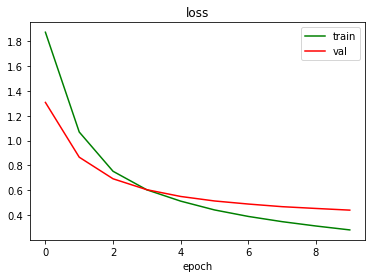

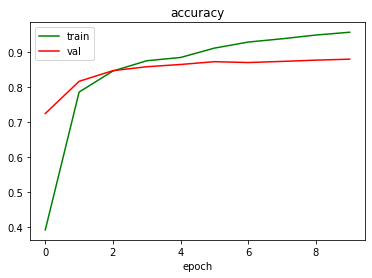

In [91]:
plot_loss_accuracy(history3)

**Little overfitting and validation accuracy is not increasing much**

### Upload TensorBoard dev records

In [92]:
!tensorboard dev upload --logdir /tensorflow_hub/ \
  --name "EfficientNetB0 v/s Resnet50v2" \
  --description "Comparing two different features extractors from Tensoflow Hub " \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/KSzsaRJSQnObr5GYdBRqRQ/

[2022-08-10T04:03:35] Started scanning logdir.
[2022-08-10T04:03:38] Total uploaded: 120 scalars, 0 tensors, 3 binary objects (9.4 MB)
[2022-08-10T04:03:38] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/KSzsaRJSQnObr5GYdBRqRQ/


In [93]:
!tensorboard dev list

https://tensorboard.dev/experiment/KSzsaRJSQnObr5GYdBRqRQ/
	Name                 EfficientNetB0 v/s Resnet50v2
	Description          Comparing two different features extractors from Tensoflow Hub 
	Id                   KSzsaRJSQnObr5GYdBRqRQ
	Created              2022-08-10 04:03:35 (26 seconds ago)
	Updated              2022-08-10 04:03:38 (23 seconds ago)
	Runs                 6
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  9873153
Total: 1 experiment(s)


In [58]:
#!tensorboard dev delete --experiment_id jX4R9nlmT5KfQpetyyyfog

Deleted experiment jX4R9nlmT5KfQpetyyyfog.
